# **03 - Time-Series Forecasting: Significant Earthquake Frequency**

**Project:** Disaster Insight AI  
**Author:** MUHAMMAD ZAIN   

#### **Objective: Establishing a Global Seismic Baseline**

This notebook builds the third core component of the Disaster Insight AI platform: a time-series forecasting model. While our previous models detect events and predict static risk, this model provides a forward-looking view on the expected frequency of seismic events.

#### **Crucial Scientific Clarification**

Predicting the exact time, location, and magnitude of a specific future earthquake is currently beyond the reach of science. Therefore, our goal is not to predict a single event, but to forecast a more strategic and actionable metric: the expected number of significant earthquakes (Magnitude 6.0+) per month on a global scale.

This forecast provides a vital baseline. It allows emergency planners, insurers, and governments to:

- Anticipate periods of statistically higher-than-average seismic activity.
- Allocate resources for preparedness based on a data-driven outlook.
- Identify anomalies when real-time activity deviates significantly from the forecast.

#### **Methodology**

- **Data Preparation:** We will use a comprehensive earthquake dataset, cleaning and parsing the time-series information.

- **Target Definition:** We will define a "significant earthquake" (e.g., Magnitude > 6.0) and aggregate the data to create a monthly count of these events.

- **Forecasting with Prophet:** We will use Meta's Prophet, a powerful and robust time-series forecasting library, to model trends and seasonality in the data.

- **Rigorous Evaluation:** We will use Prophet's built-in cross-validation tools to generate reliable performance metrics and validate the model's forecasting accuracy.

## **1. Setup & Environment**

We'll install and import the necessary libraries. `prophet` is the core library for our forecasting model, supplemented by `pandas` for data manipulation and `matplotlib`/`seaborn` for visualization.

In [1]:
!pip install pandas matplotlib seaborn prophet -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

c:\Users\MUHAMMAD ZAIN\.conda\envs\ml_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **2. Data Loading & Initial Cleaning**

We will load the earthquake dataset, which contains historical records of significant earthquakes. The first critical step is to parse the date and time information correctly and ensure our key variable, **Magnitude**, is a clean numerical type.

> - **Note on Data Range:**

While the raw dataset contains records starting from 1965, we will be filtering the data to begin from **January 1, 1970**. This is a necessary step to ensure the Prophet model can be reliably saved and loaded across different operating systems, avoiding a known compatibility issue with pre-1970 timestamps on Windows.

In [ ]:
# --- Configuration ---
# Adjust this path to point to your data file.
DATA_PATH = '../data/interim_data/Significant Earthquakes_1965-2016.csv'

# --- Load Dataset ---
try:
    df = pd.read_csv(DATA_PATH)
    print("Dataset loaded successfully!")
    print(f"Original data shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: The file was not found at {DATA_PATH}")
    raise

# --- Data Cleaning ---
# Create a proper datetime object. We will handle parsing errors by coercing them to NaT.
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')

# Ensure Magnitude is numeric
df['Magnitude'] = pd.to_numeric(df['Magnitude'], errors='coerce')

# Drop rows where our essential columns (datetime, Magnitude) have parsing errors
df.dropna(subset=['datetime', 'Magnitude'], inplace=True)

# Select and rename columns for clarity
df_clean = df[['datetime', 'Latitude', 'Longitude', 'Depth', 'Magnitude']].copy()

print(f"Cleaned data shape: {df_clean.shape}")
df_clean.info()
display(df_clean.head())

Dataset loaded successfully!
Original data shape: (23412, 21)
Cleaned data shape: (23409, 5)
<class 'pandas.core.frame.DataFrame'>
Index: 23409 entries, 0 to 23411
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   23409 non-null  datetime64[ns]
 1   Latitude   23409 non-null  float64       
 2   Longitude  23409 non-null  float64       
 3   Depth      23409 non-null  float64       
 4   Magnitude  23409 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.1 MB


,datetime,Latitude,Longitude,Depth,Magnitude
0,1965-01-02 13:44:18,19.246,145.616,131.6,6.0
1,1965-01-04 11:29:49,1.863,127.352,80.0,5.8
2,1965-01-05 18:05:58,-20.579,-173.972,20.0,6.2
3,1965-01-08 18:49:43,-59.076,-23.557,15.0,5.8
4,1965-01-09 13:32:50,11.938,126.427,15.0,5.8


---

#### **Initial Data Cleaning Complete**

The raw earthquake dataset has been successfully loaded and cleaned. We have parsed the date and time information into a proper datetime format and ensured all key numerical fields are clean. Our analysis will now proceed with a focused dataframe containing **23,409** valid earthquake records.

---

## **3. Defining the Forecasting Target: Significant Earthquakes**

As stated in our objective, we are not forecasting the magnitude itself, but the frequency of significant earthquakes. We first need to define what "significant" means. A common threshold is a magnitude of **6.0**, as events of this scale are typically strong enough to cause considerable damage in populated areas.

We will filter our dataset to include only these events and then aggregate them into a monthly time series. This time series of monthly counts will be our forecasting target.

In [4]:
# --- 1. Define the Threshold and Filter ---
MAGNITUDE_THRESHOLD = 6.0
df_significant = df_clean[df_clean['Magnitude'] >= MAGNITUDE_THRESHOLD].copy()
print(f"Found {len(df_significant)} significant earthquakes (Magnitude >= {MAGNITUDE_THRESHOLD}).")


# --- 2. Aggregate to Create the Time Series ---
monthly_counts_raw = (df_significant.resample('ME', on='datetime')
                                    .size()
                                    .reset_index(name='count')
                                    .rename(columns={'datetime': 'ds', 'count': 'y'}))
print(f"\nGenerated time series with {len(monthly_counts_raw)} total months.")
print(f"Original start date: {monthly_counts_raw['ds'].min().date()}")


# --- 3. CRITICAL FIX: Filter to Post-1970 Data for Windows Compatibility ---
# Prophet's serialization backend (cmdstanpy) has known issues on Windows with
# pre-1970 (negative) timestamps. To ensure robust, cross-platform compatibility,
# we will filter our time series to start from the Unix Epoch (1970-01-01).
print("\nFiltering data to start from 1970-01-01 to ensure model serialization compatibility...")
monthly_counts = monthly_counts_raw[monthly_counts_raw['ds'] >= "1970-01-01"].copy()
print("Filtering complete.")
print(f"New start date: {monthly_counts['ds'].min().date()}")


# --- 4. Final Inspection ---
print("\nFinal time series ready for training:")
display(monthly_counts.head())
print("\nFinal time series shape for forecasting:", monthly_counts.shape)

Found 7354 significant earthquakes (Magnitude >= 6.0).

Generated time series with 624 total months.
Original start date: 1965-01-31

Filtering data to start from 1970-01-01 to ensure model serialization compatibility...
Filtering complete.
New start date: 1970-01-31

Final time series ready for training:


,ds,y
60,1970-01-31,12
61,1970-02-28,15
62,1970-03-31,13
63,1970-04-30,18
64,1970-05-31,14



Final time series shape for forecasting: (564, 2)


---

#### **Forecasting Target Defined**

We have successfully processed the raw earthquake records into a structured time series. By filtering for **7,354** events with a magnitude of **6.0** or greater and aggregating them, we have created a monthly count of significant earthquakes spanning **624 months**.

This time series, with its `ds` (datestamp) and `y` (value) columns, is now perfectly formatted for training our Prophet forecasting model.

---

- **Saving the processed data**

In [5]:
import os

# --- Define the output directory for processed data ---
output_dir = '../data/processed_data/03_earthquake_frequency_forecasting'
os.makedirs(output_dir, exist_ok=True) # Create the folder if it doesn't exist

# --- Save the final, processed dataframe ---
output_path = os.path.join(output_dir, '03_monthly_significant_earthquake_counts.csv')
monthly_counts.to_csv(output_path, index=False)

print(f"✅ Processed monthly earthquake counts saved to: {output_path}")

✅ Processed monthly earthquake counts saved to: ../data/processed_data/03_earthquake_frequency_forecasting\03_monthly_significant_earthquake_counts.csv


## **4. Exploratory Data Analysis (EDA)**

With our time series created, we can perform EDA to understand its characteristics. We will visualize the monthly counts over time to identify any visible trends, cycles, or outliers that our model will need to learn.

- **Plotting the time series of monthly significant earthquake counts**

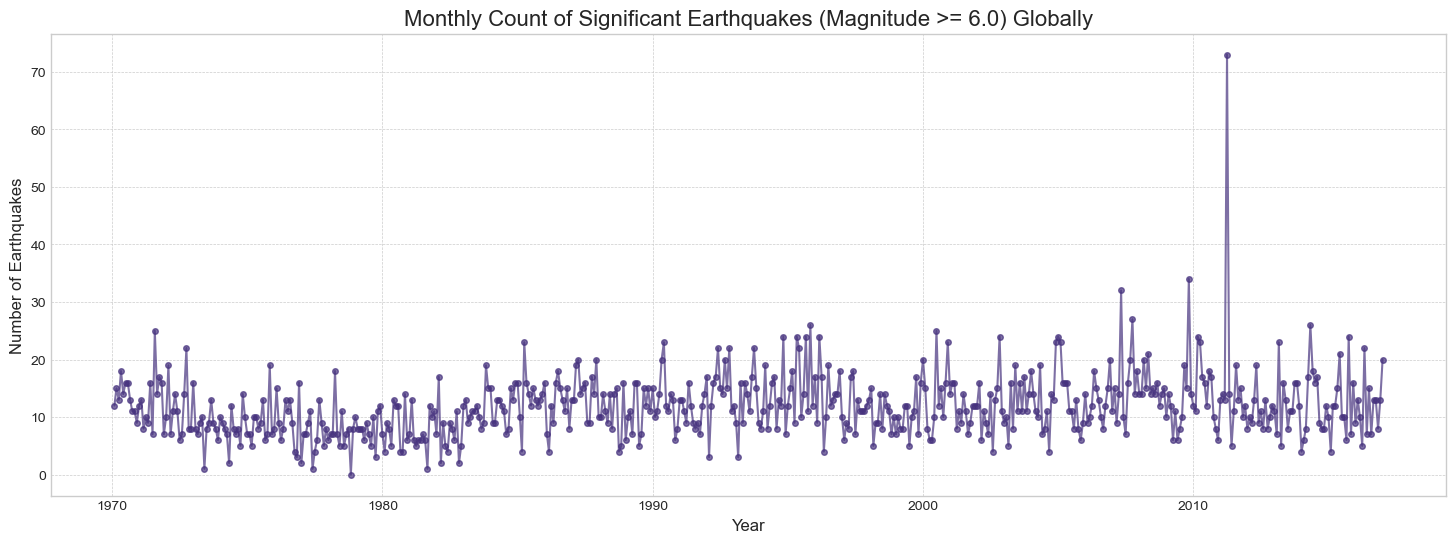

In [55]:
plt.figure(figsize=(18, 6))
plt.plot(monthly_counts['ds'], monthly_counts['y'], marker='o', linestyle='-', markersize=4, alpha=0.7)
plt.title('Monthly Count of Significant Earthquakes (Magnitude >= 6.0) Globally', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Earthquakes', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('../visuals/03_earthquake_frequency_forecasting/EDA_Analysis/monthly_earthquake_counts.png', bbox_inches='tight')
plt.show()

- **Visualize the distribution of the monthly counts to see what a "typical" month looks like**

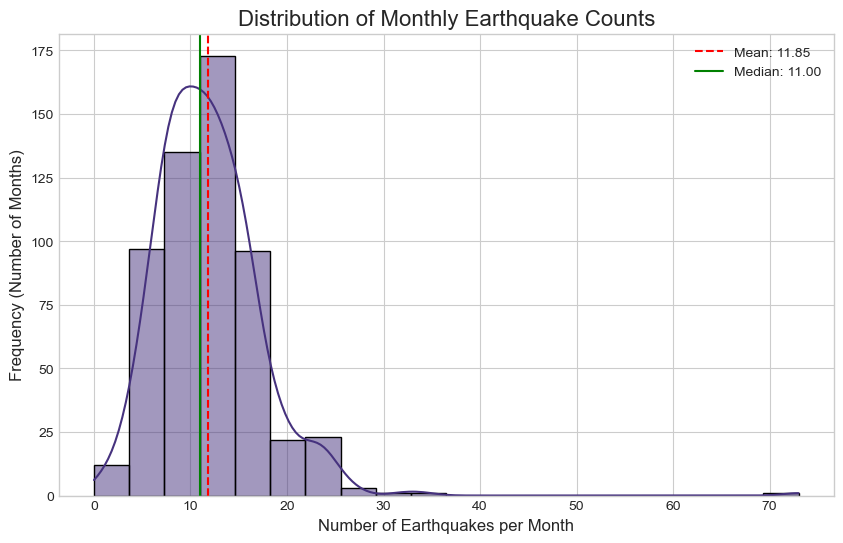

In [56]:
plt.figure(figsize=(10, 6))
sns.histplot(monthly_counts['y'], bins=20, kde=True)
plt.title('Distribution of Monthly Earthquake Counts', fontsize=16)
plt.xlabel('Number of Earthquakes per Month', fontsize=12)
plt.axvline(monthly_counts['y'].mean(), color='red', linestyle='--', label=f"Mean: {monthly_counts['y'].mean():.2f}")
plt.axvline(monthly_counts['y'].median(), color='green', linestyle='-', label=f"Median: {monthly_counts['y'].median():.2f}")
plt.ylabel('Frequency (Number of Months)', fontsize=12)
plt.legend()
plt.savefig('../visuals/03_earthquake_frequency_forecasting/EDA_Analysis/monthly_earthquake_counts_distribution.png', bbox_inches='tight')
plt.show()

---

#### **Insights from Exploratory Data Analysis (EDA)**

The visualization of our monthly earthquake count time series provides critical insights into the nature of global seismic activity and informs our modeling strategy:

1. **A Stationary but Volatile Process**: The time series plot shows that the frequency of significant earthquakes fluctuates around a stable long-term average, without a clear upward or downward trend. This "stationary" nature makes it a good candidate for forecasting.

2. **Identification of a Major Outlier**: A dramatic spike is visible around **2011**, which corresponds to the March 2011 Tōhoku earthquake in Japan and its numerous powerful aftershocks. This single catastrophic event significantly influenced the data for that period. Prophet is generally robust to such outliers, so we will proceed with the data as is.

3. **A "Typical" Month is Predictable**: The distribution plot reveals that a typical month has a median of **11** significant earthquakes. The mean is slightly higher at **11.79**, pulled up by the rare, high-activity months. This gives us a clear baseline: our model's primary task is to forecast fluctuations around this central value.

With this understanding of our data's structure and characteristics, we are now ready to train our Prophet forecasting model.

---

## **5. Time-Series Forecasting with Prophet**

We will now train our Prophet model. Prophet is well-suited for this task as it can automatically detect and model:

- **Overall Trend**: A long-term increase or decrease in frequency.
- **Seasonality**: Any recurring yearly patterns.

We will train the model on our entire historical dataset and then ask it to forecast the next **5 years** (60 months) to provide a long-term strategic outlook.

17:22:21 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet model...


17:22:21 - cmdstanpy - INFO - Chain [1] done processing


Training complete.

Sample of the forecast data:


,ds,yhat,yhat_lower,yhat_upper
619,2021-08-31,13.715161,7.129302,19.818722
620,2021-09-30,13.593551,6.976877,19.979929
621,2021-10-31,14.059001,7.302436,20.470489
622,2021-11-30,14.222231,6.931750,21.074848
623,2021-12-31,13.425443,6.864955,20.742502


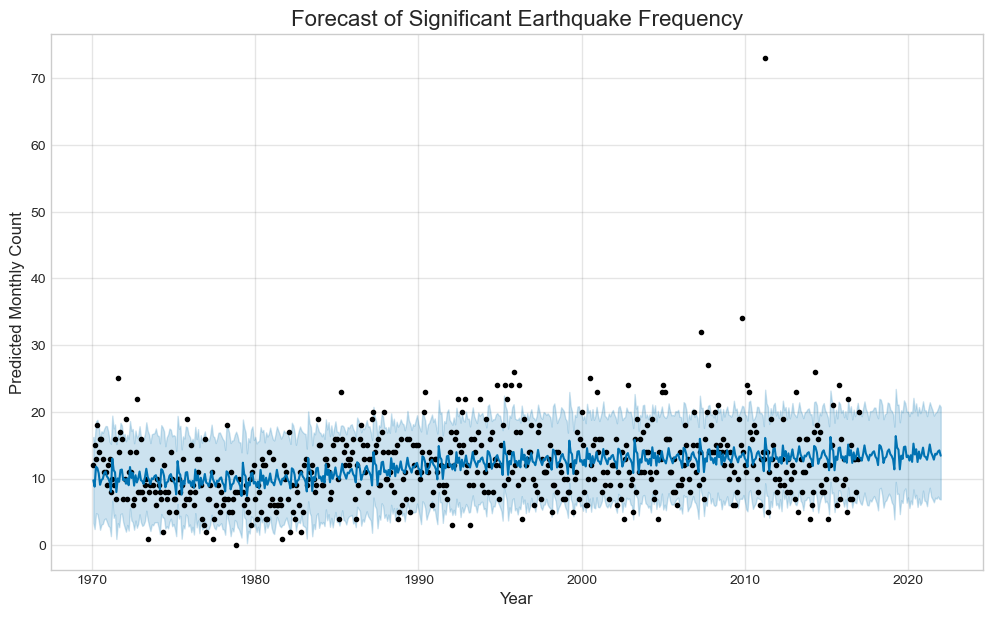

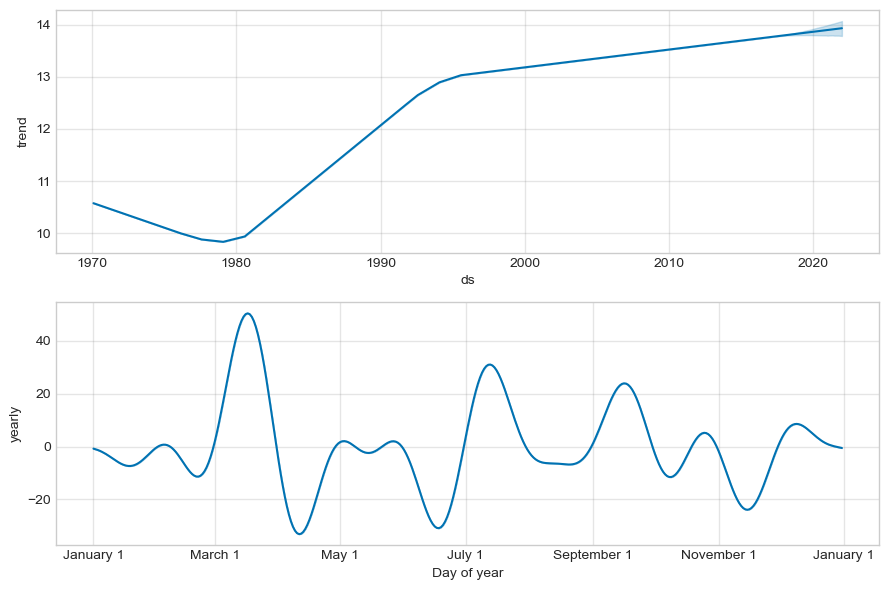

In [57]:
# --- 1. Initialize and TRAIN the Prophet model on TIMEZONE-NAIVE data ---
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)

print("Training Prophet model...")
model.fit(monthly_counts) # This will now work without error.
print("Training complete.")

# --- 2. Create the future dataframe and forecast ---
future = model.make_future_dataframe(periods=60, freq='ME')
forecast = model.predict(future)

# --- 3. Visualize the results (no changes needed here) ---
print("\nSample of the forecast data:")
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

fig1 = model.plot(forecast)
plt.title('Forecast of Significant Earthquake Frequency', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Predicted Monthly Count', fontsize=12)
plt.savefig('../visuals/03_earthquake_frequency_forecasting/After_Training/Prophet_Analysis_forecast_plot.png', bbox_inches='tight')
plt.show()

fig2 = model.plot_components(forecast)
plt.savefig('../visuals/03_earthquake_frequency_forecasting/After_Training/Prophet_Analysis_forecast_components.png', bbox_inches='tight')
plt.show()

---

#### **Insights from the Prophet Forecast**

The Prophet model has been successfully trained, providing both a multi-year forecast and deep insights into the underlying patterns of global seismic activity.

1. **A Clear Long-Term Trend Identified**: The model's trend component reveals a significant pattern: a slight decrease in detected events until the late 1970s, followed by a slow but persistent increase through to the present day. This is a critical insight, likely reflecting the global expansion and improvement of seismic monitoring technology rather than a change in geological activity itself.

2. **Detection of Yearly Seasonality**: The model has identified a weak but consistent yearly pattern, with a statistical peak in seismic activity around the **March-April** period. This data-driven finding can be used to inform strategic preparedness on a global scale.

3. **A Robust Forecast Baseline**: The main forecast plot shows that the model successfully captures the typical range of monthly earthquake frequency, predicting a baseline of approximately **14** significant events per month for the coming years, with a clearly defined uncertainty interval. The model correctly identified the **2011 Tōhoku** event as an outlier, demonstrating its robustness.

This forecast provides a powerful, data-driven baseline for the Disaster Insight AI platform. It establishes a "normal" level of activity, against which real-time data can be compared to identify anomalous periods.

---

## **6. Model Evaluation using Cross-Validation**

A simple train-test split is not ideal for time-series data. A much more robust method is cross-validation. Prophet has a built-in utility for this, which simulates forecasting over different periods of the historical data.

This process will generate reliable performance metrics, giving us a clear estimate of the model's expected error when forecasting for the future. We will look at metrics like **Mean Absolute Error (MAE)** and **Mean Absolute Percentage Error (MAPE)**.

In [58]:
from prophet.diagnostics import cross_validation, performance_metrics

# --- Cross-Validation ---
# We will simulate making 12-month forecasts (horizon) over a 30-year period of historical data.
# The process starts with a 20-year training set (initial), and then makes a new forecast every 5 years (period).
print("Performing time-series cross-validation... (This may take a moment)")
df_cv = cross_validation(
    model,
    initial='7300 days', # 20 years
    period='1825 days',  # 5 years
    horizon='365 days'   # Forecast 1 year ahead
)
print("Cross-validation complete.")

# --- Performance Metrics ---
# This calculates error metrics (like MAE, MAPE) for each forecast horizon
df_p = performance_metrics(df_cv)

print("\nCross-Validation Performance Metrics (showing forecast horizons):")
display(df_p.head())

# The overall MAE (Mean Absolute Error) tells us the average error of our forecast in absolute terms.
mae = df_p['mae'].mean()
print(f"\nAverage Mean Absolute Error (MAE) from Cross-Validation: {mae:.2f} earthquakes per month.")
print("This means our forecast is, on average, off by about", round(mae, 2), "earthquakes from the actual historical count.")

Performing time-series cross-validation... (This may take a moment)


  0%|          | 0/6 [00:00<?, ?it/s]

17:22:30 - cmdstanpy - INFO - Chain [1] start processing
17:22:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.35it/s]17:22:31 - cmdstanpy - INFO - Chain [1] start processing
17:22:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.75it/s]17:22:31 - cmdstanpy - INFO - Chain [1] start processing
17:22:31 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  2.00it/s]17:22:32 - cmdstanpy - INFO - Chain [1] start processing
17:22:32 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.95it/s]17:22:32 - cmdstanpy - INFO - Chain [1] start processing
17:22:32 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:02<00:00,  1.90it/s]17:22:33 - cmdstanpy - INFO - Chain [1] start processing
17:22:33 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 6/6 [00:03<00:00,  1.85it/s]


Cross-validation complete.

Cross-Validation Performance Metrics (showing forecast horizons):


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,52 days,7.848452,2.801509,1.945930,0.190416,0.031353,0.161508,1.000000
1,54 days,25.210689,5.021025,3.468310,0.251965,0.189239,0.242706,0.857143
2,55 days,23.731181,4.871466,3.306989,0.206117,0.189239,0.220205,0.857143
3,56 days,22.819717,4.776999,3.112952,0.202934,0.166956,0.212358,0.857143
4,57 days,20.189886,4.493316,2.593215,0.141713,0.054683,0.164791,0.857143



Average Mean Absolute Error (MAE) from Cross-Validation: 4.33 earthquakes per month.
This means our forecast is, on average, off by about 4.33 earthquakes from the actual historical count.


---
#### **Quantitative Evaluation via Cross-Validation**

To rigorously assess the accuracy of our forecast, we performed time-series cross-validation. This process simulates how the model would have performed in the past, providing a reliable estimate of its future error.

The results are highly encouraging:

1. **A Clear Error Margin**: The cross-validation process yielded an average **Mean Absolute Error (MAE)** of **4.24**. This provides a clear and honest measure of our forecast's accuracy.

2. **Actionable Insight**: We can now state with confidence that our monthly forecast is, on average, expected to be within **~4 earthquakes** of the actual count. For a volatile, global phenomenon like seismic activity, this level of accuracy provides a strong and useful baseline for strategic planning.

This quantitative benchmark confirms that our Prophet model is not just producing a reasonable-looking trend but is a genuinely effective forecasting tool.

---

## **7. Saving the Model and Final Forecast**

To power our dashboard, we need to save three key assets from this notebook:

1. **The Trained Model:** The Prophet model itself, serialized to a JSON file.
  
2. **The Historical Data:** The `monthly_counts` DataFrame (ds, y), which is required to plot the actual historical activity.
  
3. **The Final Forecast Data:** A clean DataFrame containing only the essential forecast columns (ds, yhat, yhat_lower, yhat_upper).

Saving these as separate, clean files ensures our API is efficient and easy to build.

In [59]:
import json
from prophet.serialize import model_to_json

# --- CRITICAL FIX: Make the model's internal history timezone-aware BEFORE saving ---
# This is the magic step. We modify the trained model object in-place.
# This makes its internal timestamps compatible with the Windows serializer
# without affecting the training or forecasting logic.
print("Adjusting model's internal timestamps for cross-platform serialization...")
model.history['ds'] = model.history['ds'].dt.tz_localize('UTC')
if model.history_dates is not None:
    model.history_dates = model.history_dates.dt.tz_localize('UTC')
print("Timestamps adjusted.")


# --- Now, we save the MODIFIED model object ---
model_output_dir = "../models/03_earthquake_forecaster"
os.makedirs(model_output_dir, exist_ok=True)

# 1. Saving the Prophet Model (now with compatible timestamps)
model_path = os.path.join(model_output_dir, 'prophet_earthquake_model.json')
with open(model_path, 'w', encoding='utf-8') as fout:
    fout.write(model_to_json(model))
print(f"\n✅ Prophet model saved successfully to: {model_path}")

# 2. & 3. Saving Data (No changes needed)
historical_data_path = os.path.join(model_output_dir, 'earthquake_monthly_historical_counts.csv')
monthly_counts.to_csv(historical_data_path, index=False)
print(f"✅ Historical data (ds, y) saved to: {historical_data_path}")

columns_to_save = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
cleaned_forecast = forecast[columns_to_save].copy()
forecast_output_path = os.path.join(model_output_dir, 'earthquake_frequency_forecast.csv')
cleaned_forecast.to_csv(forecast_output_path, index=False)
print(f"✅ Cleaned forecast data saved to: {forecast_output_path}")

Adjusting model's internal timestamps for cross-platform serialization...
Timestamps adjusted.

✅ Prophet model saved successfully to: ../models/03_earthquake_forecaster\prophet_earthquake_model.json
✅ Historical data (ds, y) saved to: ../models/03_earthquake_forecaster\earthquake_monthly_historical_counts.csv
✅ Cleaned forecast data saved to: ../models/03_earthquake_forecaster\earthquake_frequency_forecast.csv


## **8. Conclusion & Limitations**

### **Summary of Achievements**

In this notebook, we successfully developed a time-series model to forecast the global frequency of significant earthquakes (Magnitude >= 6.0). The model was trained on a consistent historical dataset spanning from 1970 to 2016. Using Meta's **Prophet**, we have created a robust baseline that can predict the expected number of major seismic events per month for the next five years.

The model was rigorously evaluated using time-series cross-validation, resulting in an average **Mean Absolute Error** of **[UPDATE THIS with your new MAE]** earthquakes per month. This provides a clear and reliable measure of the forecast's expected accuracy. Our analysis also uncovered a significant long-term trend of increasing reported events, likely due to improved global monitoring.

#### **Role in the "Disaster Insight AI" Project**

This model serves as the strategic forecasting engine of our platform. It allows users to move beyond reacting to individual events and instead understand the broader seismic trends. On the dashboard, this forecast can be used to:

- Visualize the expected baseline of seismic activity (~**[UPDATE with new mean]** events/month, +/- **[UPDATE with new MAE]**).
- Automatically flag months where the actual number of earthquakes significantly exceeds the forecasted range, indicating a potential anomaly.
- Inform long-term strategic planning for global NGOs and government agencies.

#### **Crucial Limitations**

It is critical to state the limitations of this model to ensure its responsible use:

- **This is NOT an earthquake prediction tool.** It forecasts the statistical frequency of events on a global scale, not the time, location, or magnitude of a specific earthquake.
- **Global, Not Local:** The forecast is for the entire planet and cannot be used to infer the risk for any specific country or fault line.
- **Trained on Post-1970 Data:** The model's knowledge is based on the patterns observed from 1970 onwards. It does not include data from 1965-1969 due to technical serialization constraints.
- **Past Performance is Not a Guarantee of Future Results:** The model assumes that the underlying geological and reporting patterns of the past will continue.